In [99]:
import os
import json
import pandas as pd
import pickle
import random
import subprocess

In [100]:
# Directory containing the JSON files
parameters_dir = 'parameters/'

# Initialize an empty list to hold the data
data = []

# Iterate over all files in the directory
for filename in os.listdir(parameters_dir):
    if filename.endswith('.json'):
        file_path = os.path.join(parameters_dir, filename)
        
        # Read the JSON file
        with open(file_path, 'r') as f:
            parameters = json.load(f)
        
        # Extract the hash value from the filename (assuming the filename format is like '1a090417.json')
        hash_value = os.path.splitext(filename)[0]
        
        # Add the hash value to the parameters
        parameters['hash'] = hash_value
        
        # Append the parameters (as a dictionary) to the data list
        data.append(parameters)

# Convert the list of dictionaries to a pandas DataFrame
all_params = pd.DataFrame(data)

In [101]:
all_params

,genome_length,causal_loci,repr_scheme,mutrate,recomb_rate,h2,capacity_charge,initial_pop_size,subpop_number,migration_rate,BURNIN_1,BURNIN_2,COMMON_GARDEN_CYCLE,cg_duration,initial_sel_strength,final_sel_strength,initial_ne,common_garden_number,common_garden_migrants,hash
0,500000,1000,selfing,0.000001,0.000003,0.9,500,1000,17,0.01,0,50,150,3,10,0.1,500,21,10,a31c1bf6
1,500000,5,selfing,0.000001,0.000003,0.9,500,1000,17,0.01,0,50,150,3,10,0.1,500,23,10,bd225294
2,500000,3,selfing,0.000001,0.000003,0.9,500,1000,17,0.01,0,50,50,3,10,0.1,500,17,10,e5df70b5
3,500000,20,selfing,0.000001,0.000003,0.9,500,1000,17,0.01,0,50,100,3,10,0.1,500,23,10,c20142cf
4,500000,3,selfing,0.000001,0.000003,0.9,500,1000,17,0.01,0,50,100,3,10,0.1,500,19,10,41caa00b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,500000,3,selfing,0.000001,0.000003,0.9,500,1000,17,0.01,0,50,100,3,10,0.1,500,21,10,9698a5ff
104,500000,50,selfing,0.000001,0.000003,0.9,500,1000,17,0.01,0,50,100,3,10,0.1,500,23,10,00b9109c
105,500000,10,selfing,0.000001,0.000003,0.9,500,1000,17,0.01,0,50,100,3,10,0.1,500,17,10,e1023e8d
106,500000,100,selfing,0.000001,0.000003,0.9,500,1000,17,0.01,0,50,100,3,10,0.1,500,17,10,e6143a8d


In [84]:
# Filter the DataFrame to keep only columns that have more than one unique value
all_params_filtered = all_params.loc[:, all_params.apply(pd.Series.nunique) > 1]

# View the filtered DataFrame
all_params_filtered

,causal_loci,COMMON_GARDEN_CYCLE,common_garden_number,hash
0,1000,150,21,a31c1bf6
1,5,150,23,bd225294
2,3,50,17,e5df70b5
3,20,100,23,c20142cf
4,3,100,19,41caa00b
...,...,...,...,...
103,3,100,21,9698a5ff
104,50,100,23,00b9109c
105,10,100,17,e1023e8d
106,100,100,17,e6143a8d


In [131]:
 #/env_vars/env_var_{hash}_acg_gen3.csv'

In [25]:
import allel

In [310]:
for hash in all_params['hash'].unique():
    
    allele_counts = pd.read_csv(f'results/alleles_df/allele_counts_{hash}_acg_gen3.csv').drop('Unnamed: 0',axis=1)
    
    allele_freq = pd.read_csv(f'results/alleles_df/allele_freq_{hash}_acg_gen3.csv').drop('Unnamed: 0',axis=1)
    
    population_counts_file_acg_gen3 = f'results/population_counts/population_counts_{hash}_acg_gen3.pkl'
    
    with open(population_counts_file_acg_gen3, 'rb') as f:
        population_counts = pickle.load(f)
    
    total_individuals = sum(population_counts.values())
    
    total_genomes = total_individuals * 2
    
    vcf = allel.read_vcf(f'results/vcfs/vcf_{hash}_acg_gen3.vcf')
    
    allele_freq.index = vcf['variants/POS']
    allele_counts.index = vcf['variants/POS']
    
    for min_freq in [0.6]:
        min_freq_str = str(min_freq)
        min_count = total_genomes * min_freq
        allele_freq_filt = allele_freq[allele_counts.sum(axis=1) > min_count]
        left_pos = allele_freq_filt.index
        left_pos = pd.Series(left_pos).reset_index()
        left_pos.to_csv(f'results/test_filter_lfmm/left_pos_{min_freq_str}_{hash}.csv',index=None)
        print(len(allele_freq_filt))
        allele_freq_filt.to_csv(f'results/test_filter_lfmm/allele_freq_filter_{min_freq_str}_{hash}.csv',index=None)

718
528
481
519
547
524
628
533
651
531
510
500
483
598
524
629
498
512
545
558
529
707
497
537
548
497
554
539
482
535
556
524
788
544
585
430
531
507
535
492
627
549
497
475
530
487
533
489
506
509
648
691
574
551
512
654
545
743
527
594
514
456
481
572
593
694
667
722
530
511
515
552
537
645
474
538
499
515
611
482
540
499
540
502
491
518
470
526
518
534
558
713
565
537
516
515
516
540
556
531
518
480
568
492
542
502
511
613


In [199]:
!pwd - P

/carnegie/nobackup/scratch/tbellagio/simulations/cline_creation


In [333]:
list_min_freq_str = []
for min_freq in [0,0.01,0.05,0.1,0.2,0.3,0.4,0.5, 0.6]:
    str_min_freq = str(min_freq)
    list_min_freq_str.append(str_min_freq)

In [334]:
all_params['hash'].unique()

array(['a31c1bf6', 'bd225294', 'e5df70b5', 'c20142cf', '41caa00b',
       'a384bed9', 'ba250094', 'fdea8731', 'f134e6e8', 'c5f4ab86',
       '86deaff4', 'f38d74ef', 'f287102a', '3b244293', 'e787cdc4',
       'da2df6ef', '6c575e2d', '9ba7c0c3', '317fc610', 'c25a2acf',
       'ca9f80a0', '1895d8cc', 'd672b46a', '04cce490', '1de99c21',
       '17ec02b6', 'c94d316a', '699b71e6', 'b47352d0', '3a16cb42',
       '9f2501ce', 'a40b3879', 'dc101f59', '55ac5475', '500387eb',
       '2d63a6c9', '848eab91', '63eb8121', 'ca4df532', '512cad59',
       'b99e5248', 'efc81944', 'c991de52', '6030998d', '6e735edb',
       '02d6302e', 'ddc11b79', '8bdb44c2', '5d0d3bd3', 'd6f00351',
       '6a28ce18', 'c6b626e5', 'e26417a3', 'ac1028c5', '5aab78ca',
       '48aad4d5', 'af5585ac', '8ab09e1d', '9d874a31', '920cf4b9',
       '8fdc8535', 'c25325ee', '8d513f7c', '2d1c6724', '4a9ef88e',
       'd83e6c20', 'fd30fe15', '0d0ee9cb', '313ab071', 'cf289a1b',
       'cfbad469', 'f7245e49', '0e833e58', '857cfc61', 'a90f0b

In [314]:
wd = '/carnegie/nobackup/scratch/tbellagio/simulations/cline_creation/'

# Assuming splits_samples is defined elsewhere
shfiles = []
for hash in all_params['hash'].unique():
    for min_freq_str in ['0.6']:
        allele_freq_file = f'results/test_filter_lfmm/allele_freq_filter_{min_freq_str}_{hash}.csv'
        env_var_file = f'results/lfmm/env_vars/env_var_{hash}_acg_gen3.csv'
        output_file = f'results/test_filter_lfmm/pvalues_filter_{hash}_{min_freq_str}.csv'
        seed = random.randint(1, 100000000)
        file = wd + f'sh_files/lfmm_{min_freq_str}_{hash}.sh'
        # Format the commands with proper handling of list conversion to string
        cmd2 = f'Rscript lfmm_full_compare_filter.R "{allele_freq_file}" "{env_var_file}" "{output_file}"'   # Pass necessary args to R script
        text = f'''#!/bin/bash
#SBATCH --job-name=lfmm_{min_freq_str}_{hash}
#SBATCH --time=1:00:00
#SBATCH --ntasks=1
#SBATCH --mem=120G
#SBATCH --cpus-per-task=21  
#SBATCH --output=lfmm_{min_freq_str}_{hash}-%j.out       
#SBATCH --error=lfmm_{min_freq_str}_{hash}-%j.log         
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

echo start
source /home/tbellagio/miniforge3/etc/profile.d/conda.sh

export PATH="${{PATH}}:/home/username/bin"

cd '/carnegie/nobackup/scratch/tbellagio/simulations/cline_creation'

conda activate /home/tbellagio/miniforge3/envs/r-environment
    {cmd2}
    '''
    
        with open(file, 'w') as o:
            o.write(text)
        shfiles.append(file)
    
    

In [315]:
shfiles

['/carnegie/nobackup/scratch/tbellagio/simulations/cline_creation/sh_files/lfmm_0.6_a31c1bf6.sh',
 '/carnegie/nobackup/scratch/tbellagio/simulations/cline_creation/sh_files/lfmm_0.6_bd225294.sh',
 '/carnegie/nobackup/scratch/tbellagio/simulations/cline_creation/sh_files/lfmm_0.6_e5df70b5.sh',
 '/carnegie/nobackup/scratch/tbellagio/simulations/cline_creation/sh_files/lfmm_0.6_c20142cf.sh',
 '/carnegie/nobackup/scratch/tbellagio/simulations/cline_creation/sh_files/lfmm_0.6_41caa00b.sh',
 '/carnegie/nobackup/scratch/tbellagio/simulations/cline_creation/sh_files/lfmm_0.6_a384bed9.sh',
 '/carnegie/nobackup/scratch/tbellagio/simulations/cline_creation/sh_files/lfmm_0.6_ba250094.sh',
 '/carnegie/nobackup/scratch/tbellagio/simulations/cline_creation/sh_files/lfmm_0.6_fdea8731.sh',
 '/carnegie/nobackup/scratch/tbellagio/simulations/cline_creation/sh_files/lfmm_0.6_f134e6e8.sh',
 '/carnegie/nobackup/scratch/tbellagio/simulations/cline_creation/sh_files/lfmm_0.6_c5f4ab86.sh',
 '/carnegie/nobackup

In [316]:
for file in shfiles:
    subprocess.run(['sbatch', file])

Submitted batch job 29996
Submitted batch job 29997
Submitted batch job 29998
Submitted batch job 29999
Submitted batch job 30000
Submitted batch job 30001
Submitted batch job 30002
Submitted batch job 30003
Submitted batch job 30004
Submitted batch job 30005
Submitted batch job 30006
Submitted batch job 30007
Submitted batch job 30008
Submitted batch job 30009
Submitted batch job 30010
Submitted batch job 30011
Submitted batch job 30012
Submitted batch job 30013
Submitted batch job 30014
Submitted batch job 30015
Submitted batch job 30016
Submitted batch job 30017
Submitted batch job 30018
Submitted batch job 30019
Submitted batch job 30020
Submitted batch job 30021
Submitted batch job 30022
Submitted batch job 30023
Submitted batch job 30024
Submitted batch job 30025
Submitted batch job 30026
Submitted batch job 30027
Submitted batch job 30028
Submitted batch job 30029
Submitted batch job 30030
Submitted batch job 30031
Submitted batch job 30032
Submitted batch job 30033
Submitted ba

In [335]:
results = {}
for hash in all_params['hash'].unique():
   
    for min_freq_str in list_min_freq_str:
        # Load causal loci and check for required files
        
        causal_loci = pd.read_csv(f'results/causal_loci/causal_loci_{hash}.txt', header=None)[0]
        left_pos_file = f'results/test_filter_lfmm/left_pos_{min_freq_str}_{hash}.csv'
        pvalues_file = f'results/test_filter_lfmm/pvalues_filter_{hash}_{min_freq_str}.csv'
        
        # Load files and concatenate p-values with positions
        left_pos = pd.read_csv(left_pos_file)
        pvalues = pd.read_csv(pvalues_file)
        pvalues = pd.concat([left_pos, pvalues], axis=1).drop(['index', 'Unnamed: 0'], axis=1)
        pvalues.columns = ['pos', 'pvalue']
        
        th = 0.05 / len(pvalues)  # Threshold for significance
        pvalues['sign'] = pvalues['pvalue'] <= th
        
        # Calculate true positives
        pvalues['is_true_positive'] = False
        pvalues.loc[(pvalues['pos'].isin(causal_loci)) & (pvalues['sign'] == True), 'is_true_positive'] = True
        
        # Calculate false positives
        pvalues['is_false_positive'] = False
        pvalues.loc[(~pvalues['pos'].isin(causal_loci)) & (pvalues['sign'] == True), 'is_false_positive'] = True
        
        true_positives = len(pvalues[pvalues['is_true_positive'] == True])
        false_positives = len(pvalues[pvalues['is_false_positive'] == True])

        if true_positives > len(causal_loci):
            total_causal_loci = true_positives
        else:
            total_causal_loci = len(causal_loci)
        
        # Calculate false negatives
        false_negatives = total_causal_loci - true_positives
        
        # Calculate precision, recall, and power
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / total_causal_loci if total_causal_loci > 0 else 0
        power = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        
        # Store results
        results[min_freq_str] = [hash, total_causal_loci, true_positives, false_positives, false_negatives, len(pvalues), precision, recall, power]

    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results).T
    results_df = results_df.reset_index()
    
    # Save results to a CSV file
    results_df.to_csv(f'results/test_filter_lfmm/{hash}_results.csv')


In [336]:
results = [i for i in os.listdir('results/test_filter_lfmm/') if '_results' in i]

In [337]:
all = {}
for i in results:
    df = pd.read_csv('results/test_filter_lfmm/' + i)
    all[i] = df

In [338]:
combined_df = pd.concat(all.values(), ignore_index=True).drop('Unnamed: 0',axis=1)

In [339]:
combined_df.columns = ['filtering', 'hash', 'causal','true_pos', 'false_pos', 'false_negatives', 'len', 'precision', 'recall', 'power']

In [340]:
combined_df['hash'] = combined_df['hash'].astype(str)

In [341]:
combined_df = combined_df.merge(all_params_filtered, on = 'hash', how='left')

In [342]:
combined_df.common_garden_number.value_counts()

common_garden_number
17    243
19    243
21    243
23    243
Name: count, dtype: int64

In [343]:
combined_df.COMMON_GARDEN_CYCLE.value_counts()

COMMON_GARDEN_CYCLE
100    324
50     324
150    324
Name: count, dtype: int64

In [344]:
import numpy as np

In [345]:
combined_df['causal_str'] = combined_df['causal'].astype(str)

In [346]:
order_causal = ['1', '3', '5', '10', '20', '50', '100', '500', '1000']

In [347]:
combined_df['filtering_str'] = combined_df['filtering'].astype(str)
combined_df['causal_loci'] = combined_df['causal_loci'].astype(str)

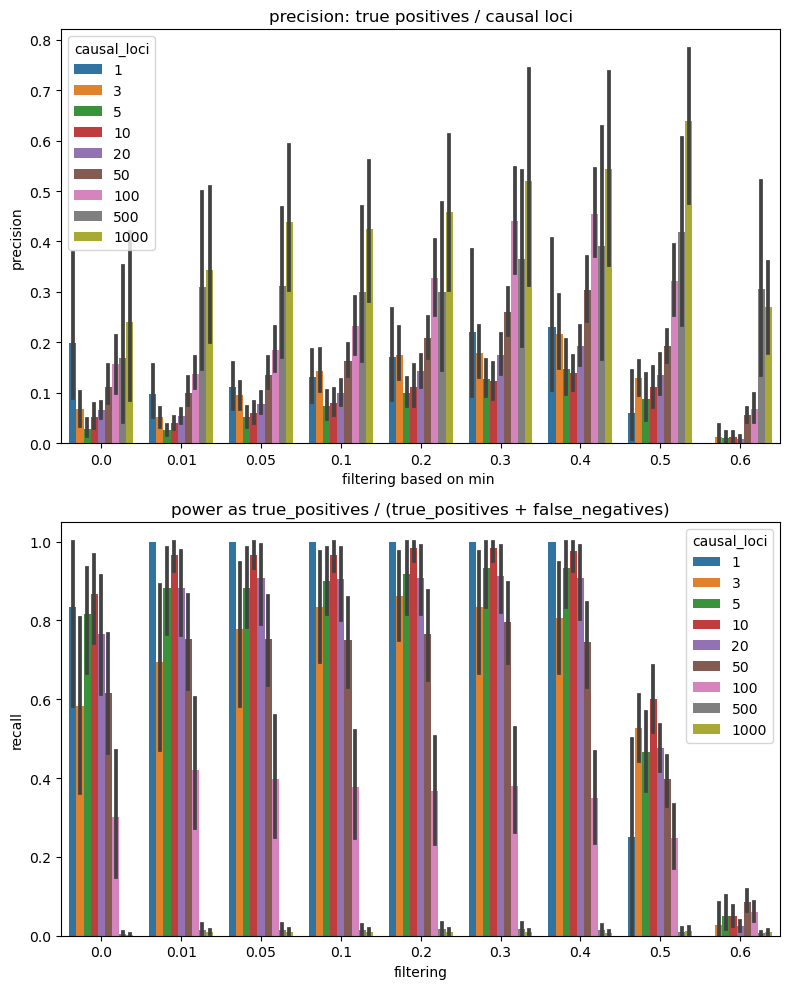

In [348]:
df = combined_df.copy()

# Create the subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 10))  # 1 row, 2 columns

# Plot the true positives in the first subplot
sns.barplot(data=df, x='filtering', y='precision', ax=axes[0], hue = 'causal_loci', hue_order = order_causal)
axes[0].set_title('precision: true positives / causal loci')
axes[0].set_xlabel('filtering based on min ')
axes[0].set_ylabel('precision')

# Plot the false positives in the second subplot
sns.barplot(data=df, x='filtering', y='power', ax=axes[1], hue = 'causal_loci', hue_order = order_causal)
axes[1].set_title('power as true_positives / (true_positives + false_negatives)')
axes[1].set_xlabel('filtering')
axes[1].set_ylabel('recall')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

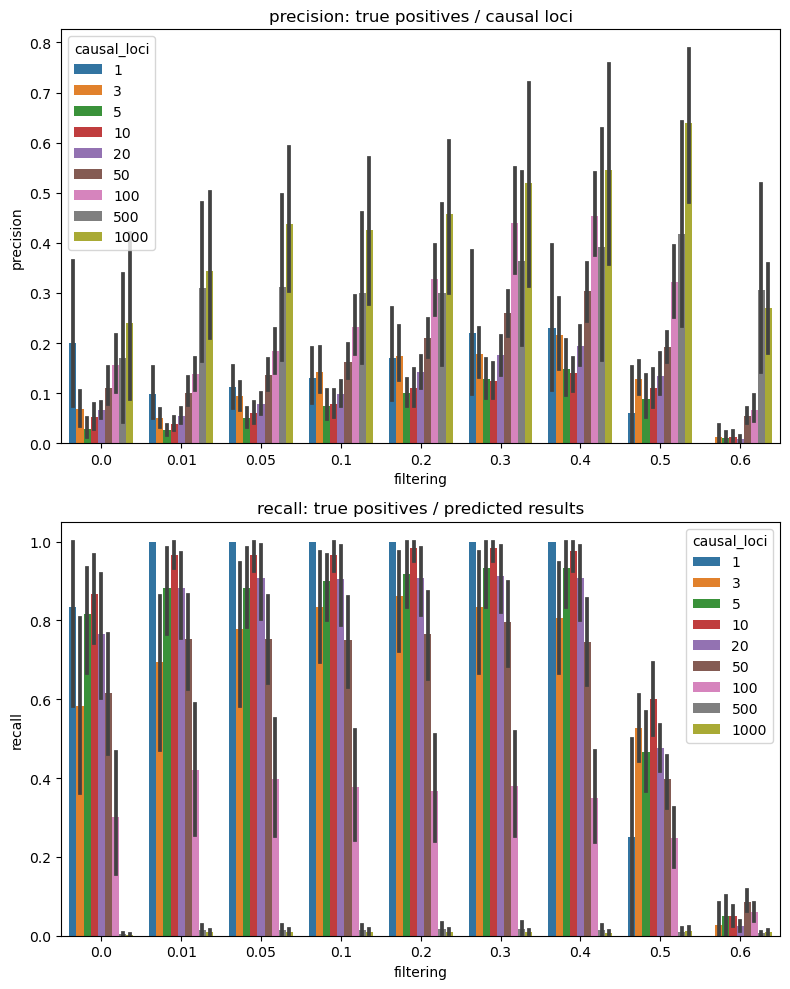

In [349]:
df = combined_df.copy()

# Create the subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 10))  # 1 row, 2 columns

# Plot the true positives in the first subplot
sns.barplot(data=df, x='filtering', y='precision', ax=axes[0], hue = 'causal_loci', hue_order = order_causal)
axes[0].set_title('precision: true positives / causal loci')
axes[0].set_xlabel('filtering')
axes[0].set_ylabel('precision')

# Plot the false positives in the second subplot
sns.barplot(data=df, x='filtering', y='recall', ax=axes[1], hue = 'causal_loci', hue_order = order_causal)
axes[1].set_title('recall: true positives / predicted results')
axes[1].set_xlabel('filtering')
axes[1].set_ylabel('recall')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

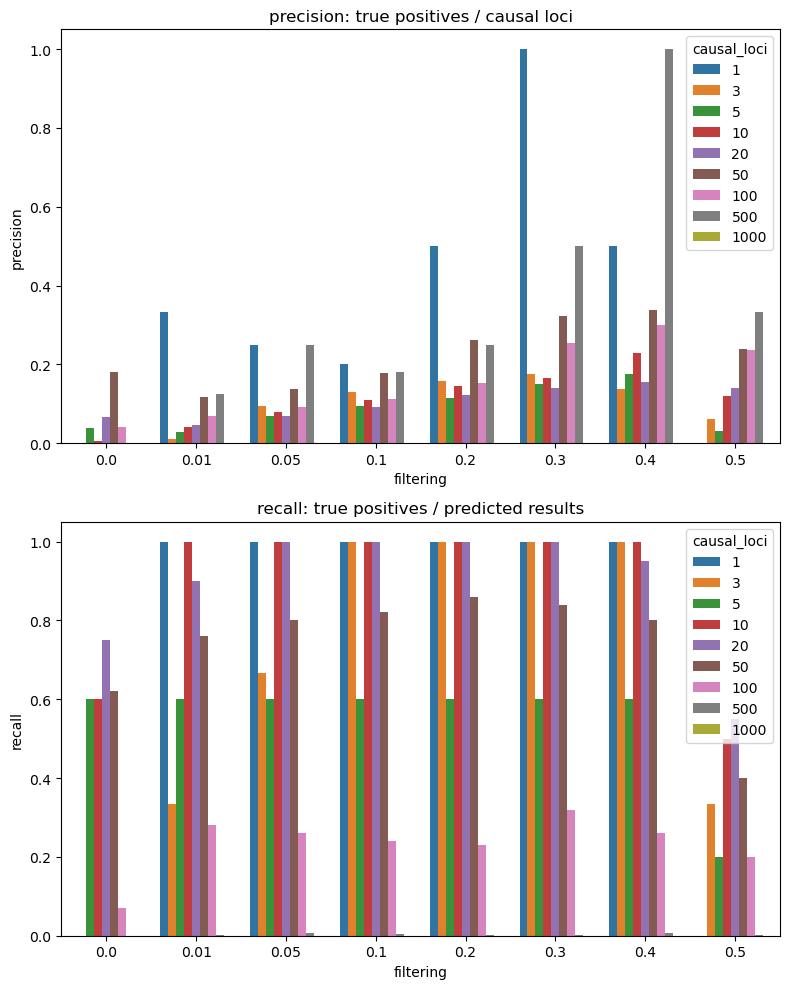

In [278]:
df = combined_df[(combined_df['common_garden_number'] ==17) & (combined_df['COMMON_GARDEN_CYCLE'] == 100)]

# Create the subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 10))  # 1 row, 2 columns

# Plot the true positives in the first subplot
sns.barplot(data=df, x='filtering', y='precision', ax=axes[0], hue = 'causal_loci', hue_order = order_causal)
axes[0].set_title('precision: true positives / causal loci')
axes[0].set_xlabel('filtering')
axes[0].set_ylabel('precision')

# Plot the false positives in the second subplot
sns.barplot(data=df, x='filtering', y='recall', ax=axes[1], hue = 'causal_loci', hue_order = order_causal)
axes[1].set_title('recall: true positives / predicted results')
axes[1].set_xlabel('filtering')
axes[1].set_ylabel('recall')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

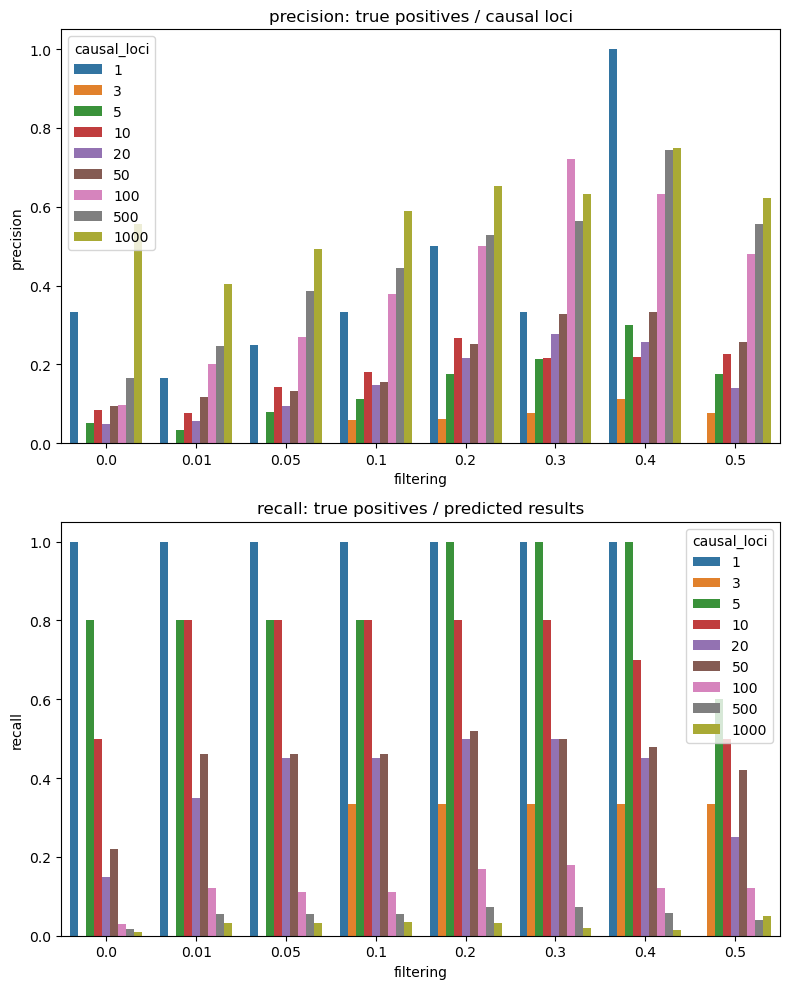

In [280]:
df = combined_df[(combined_df['common_garden_number'] ==17) & (combined_df['COMMON_GARDEN_CYCLE'] == 50)]

# Create the subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 10))  # 1 row, 2 columns

# Plot the true positives in the first subplot
sns.barplot(data=df, x='filtering', y='precision', ax=axes[0], hue = 'causal_loci', hue_order = order_causal)
axes[0].set_title('precision: true positives / causal loci')
axes[0].set_xlabel('filtering')
axes[0].set_ylabel('precision')

# Plot the false positives in the second subplot
sns.barplot(data=df, x='filtering', y='recall', ax=axes[1], hue = 'causal_loci', hue_order = order_causal)
axes[1].set_title('recall: true positives / predicted results')
axes[1].set_xlabel('filtering')
axes[1].set_ylabel('recall')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

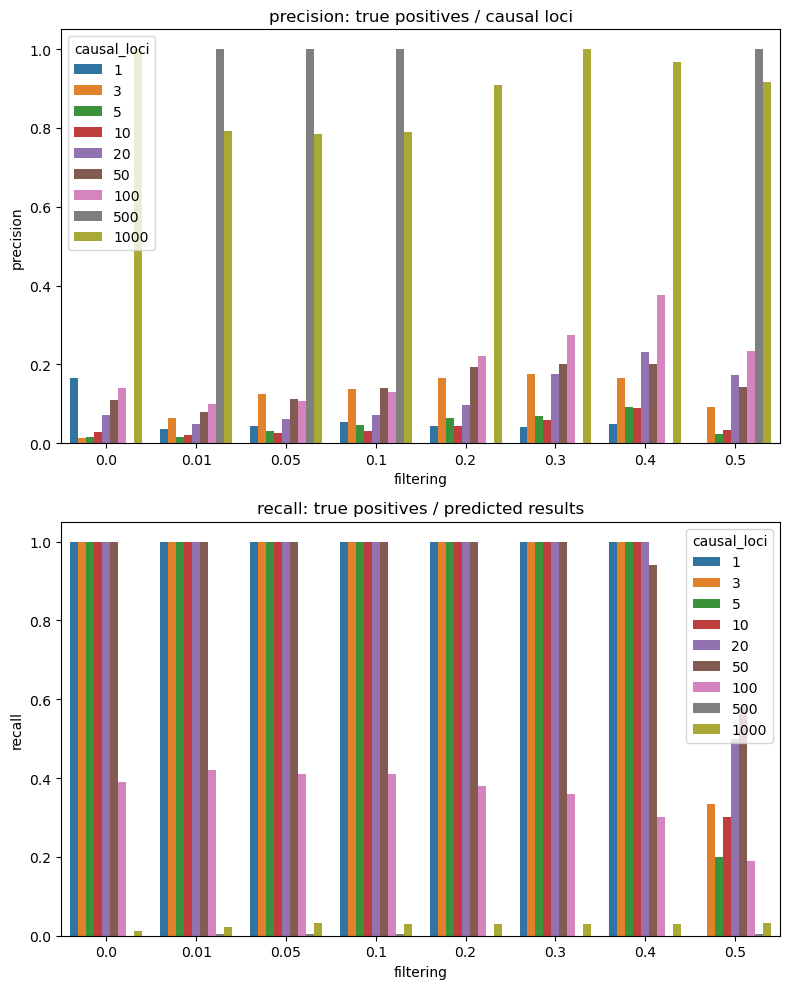

In [279]:
df = combined_df[(combined_df['common_garden_number'] ==23) & (combined_df['COMMON_GARDEN_CYCLE'] == 100)]

# Create the subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 10))  # 1 row, 2 columns

# Plot the true positives in the first subplot
sns.barplot(data=df, x='filtering', y='precision', ax=axes[0], hue = 'causal_loci', hue_order = order_causal)
axes[0].set_title('precision: true positives / causal loci')
axes[0].set_xlabel('filtering')
axes[0].set_ylabel('precision')

# Plot the false positives in the second subplot
sns.barplot(data=df, x='filtering', y='recall', ax=axes[1], hue = 'causal_loci', hue_order = order_causal)
axes[1].set_title('recall: true positives / predicted results')
axes[1].set_xlabel('filtering')
axes[1].set_ylabel('recall')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

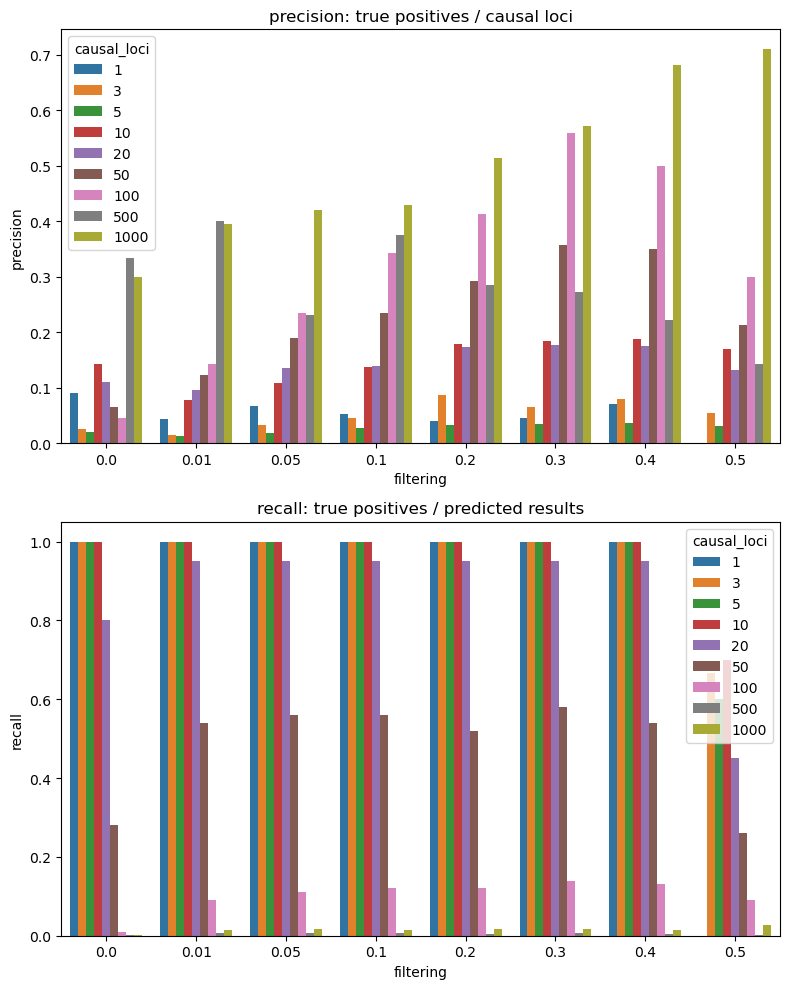

In [281]:
df = combined_df[(combined_df['common_garden_number'] ==23) & (combined_df['COMMON_GARDEN_CYCLE'] == 50)]

# Create the subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 10))  # 1 row, 2 columns

# Plot the true positives in the first subplot
sns.barplot(data=df, x='filtering', y='precision', ax=axes[0], hue = 'causal_loci', hue_order = order_causal)
axes[0].set_title('precision: true positives / causal loci')
axes[0].set_xlabel('filtering')
axes[0].set_ylabel('precision')

# Plot the false positives in the second subplot
sns.barplot(data=df, x='filtering', y='recall', ax=axes[1], hue = 'causal_loci', hue_order = order_causal)
axes[1].set_title('recall: true positives / predicted results')
axes[1].set_xlabel('filtering')
axes[1].set_ylabel('recall')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
df = combined_df[(combined_df['common_garden_number'] ==23) & (combined_df['COMMON_GARDEN_CYCLE'] == 50)]

# Create the subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 10))  # 1 row, 2 columns

# Plot the true positives in the first subplot
sns.barplot(data=df, x='filtering', y='precision', ax=axes[0], hue = 'causal_loci', hue_order = order_causal)
axes[0].set_title('precision: true positives / causal loci')
axes[0].set_xlabel('filtering')
axes[0].set_ylabel('precision')

# Plot the false positives in the second subplot
sns.barplot(data=df, x='filtering', y='recall', ax=axes[1], hue = 'causal_loci', hue_order = order_causal)
axes[1].set_title('recall: true positives / predicted results')
axes[1].set_xlabel('filtering')
axes[1].set_ylabel('recall')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

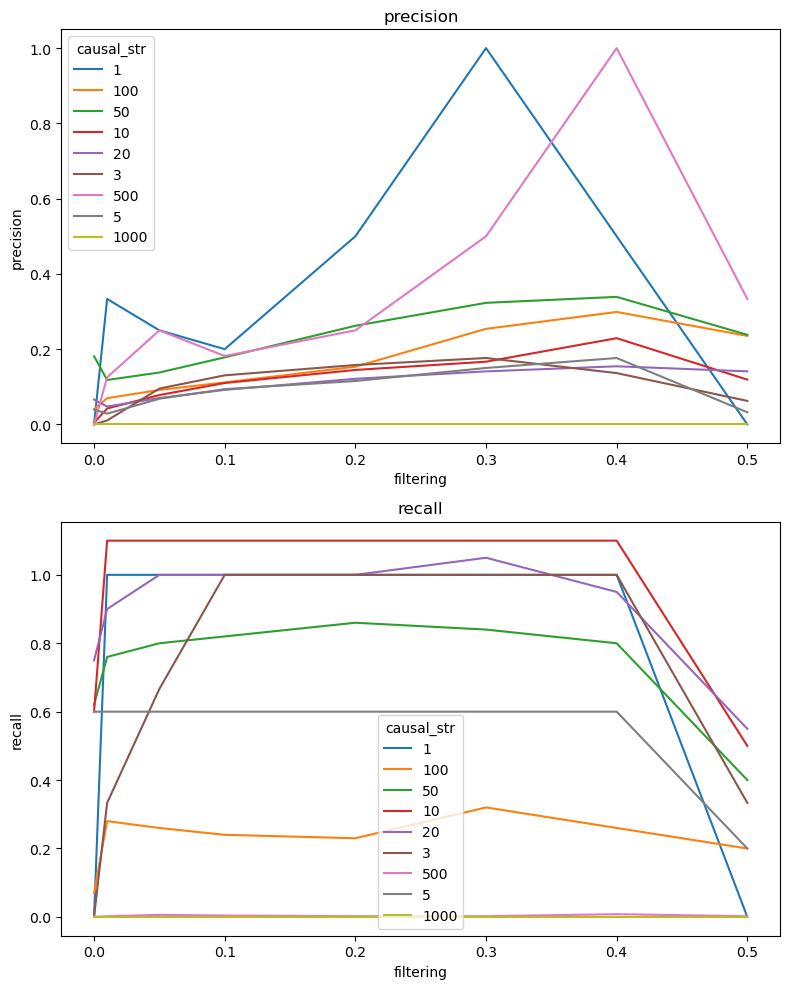

In [219]:
# Create the subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 10))  # 1 row, 2 columns

# Plot the true positives in the first subplot
sns.lineplot(data=df, x='filtering', y='precision', ax=axes[0], hue = 'causal_str')
axes[0].set_title('precision')
axes[0].set_xlabel('filtering')
axes[0].set_ylabel('precision')

# Plot the false positives in the second subplot
sns.lineplot(data=df, x='filtering', y='recall', ax=axes[1], hue = 'causal_str')
axes[1].set_title('recall')
axes[1].set_xlabel('filtering')
axes[1].set_ylabel('recall')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

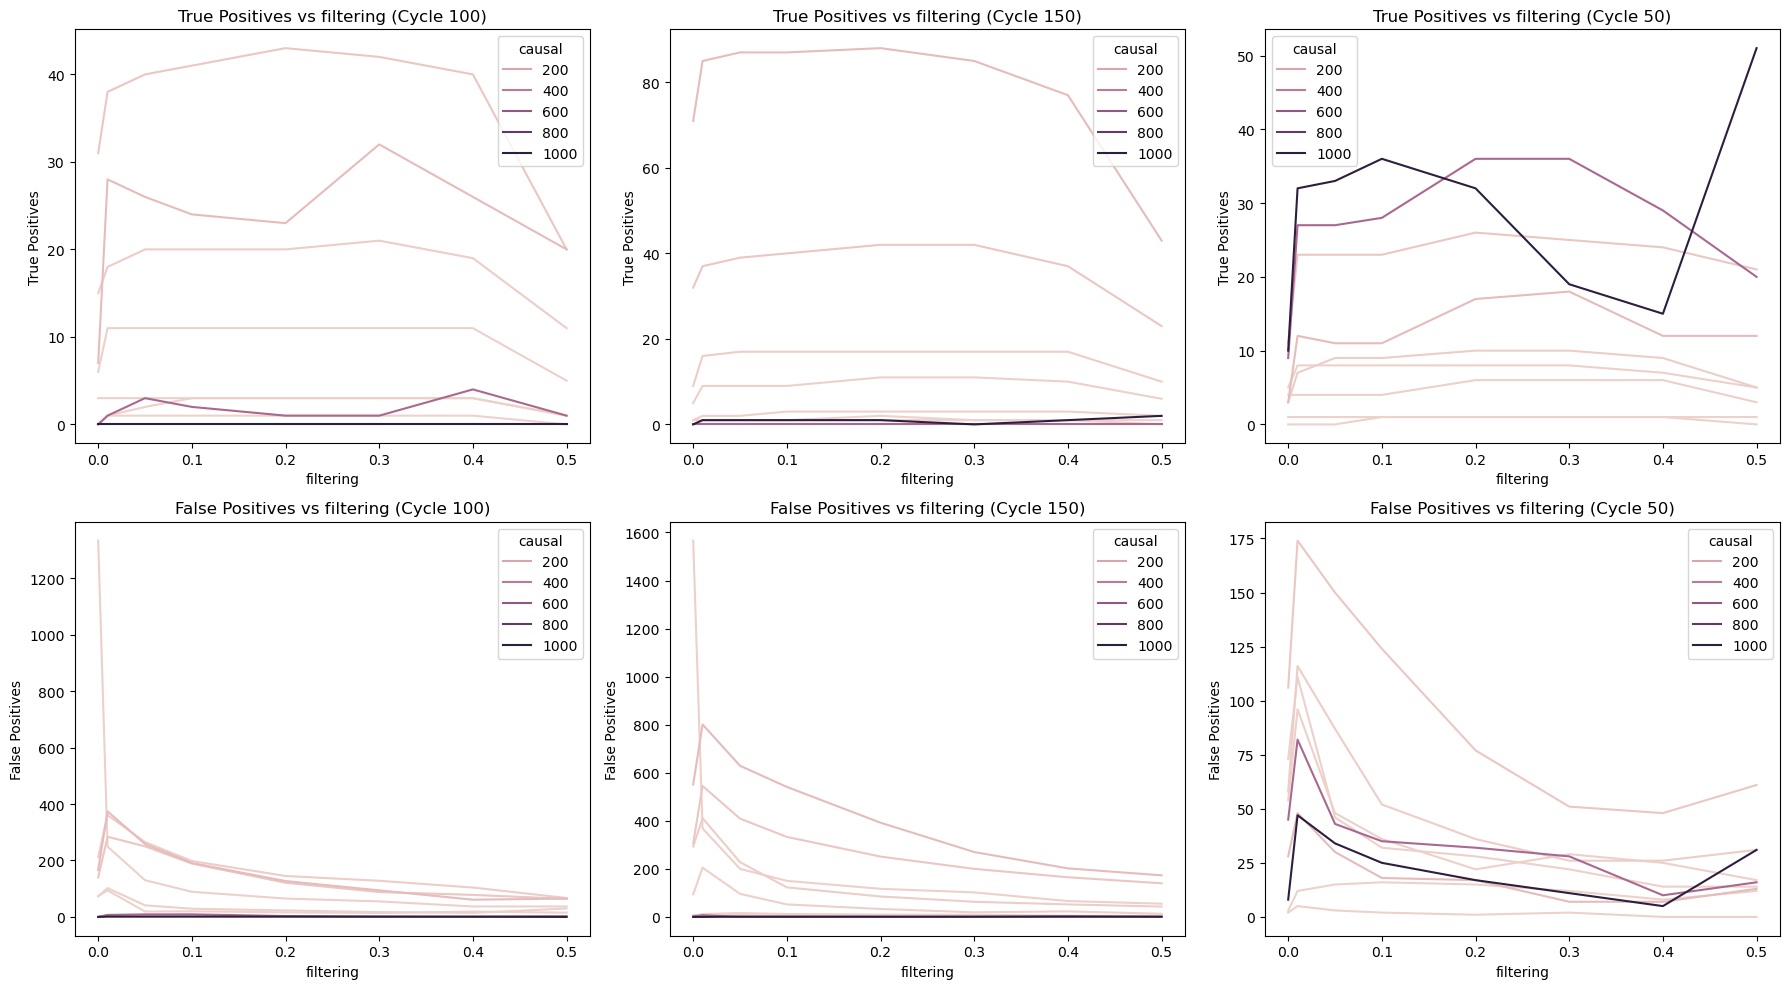

In [167]:
# Get the unique values of the COMMON_GARDEN_CYCLE column
unique_cycles = df['COMMON_GARDEN_CYCLE'].unique()

# Create the subplots, adjusting for 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns

# Plot the true positives in the first row of subplots
for i, cycle in enumerate(unique_cycles):
    sns.lineplot(data=df[df['COMMON_GARDEN_CYCLE'] == cycle], 
                 x='filtering', y='true_pos', ax=axes[0, i], hue='causal')
    axes[0, i].set_title(f'True Positives vs filtering (Cycle {cycle})')
    axes[0, i].set_xlabel('filtering')
    axes[0, i].set_ylabel('True Positives')

# Plot the false positives in the second row of subplots
for i, cycle in enumerate(unique_cycles):
    sns.lineplot(data=df[df['COMMON_GARDEN_CYCLE'] == cycle], 
                 x='filtering', y='false_pos', ax=axes[1, i], hue='causal')
    axes[1, i].set_title(f'False Positives vs filtering (Cycle {cycle})')
    axes[1, i].set_xlabel('filtering')
    axes[1, i].set_ylabel('False Positives')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()


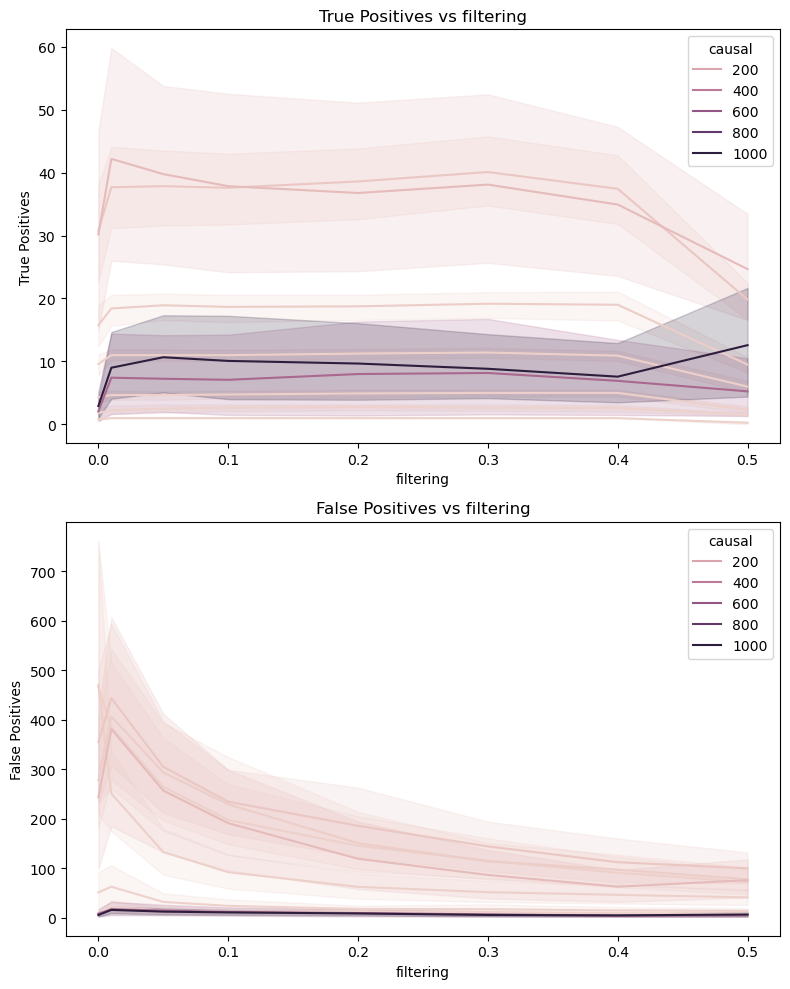

In [76]:
# Create the subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 10))  # 1 row, 2 columns

# Plot the true positives in the first subplot
sns.lineplot(data=combined_df, x='filtering', y='true_pos', ax=axes[0], hue = 'causal')
axes[0].set_title('True Positives vs filtering')
axes[0].set_xlabel('filtering')
axes[0].set_ylabel('True Positives')

# Plot the false positives in the second subplot
sns.lineplot(data=combined_df, x='filtering', y='false_pos', ax=axes[1], hue = 'causal')
axes[1].set_title('False Positives vs filtering')
axes[1].set_xlabel('filtering')
axes[1].set_ylabel('False Positives')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

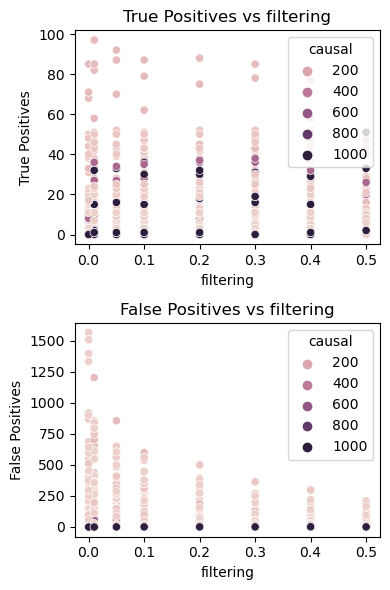

In [73]:
# Create the subplots
fig, axes = plt.subplots(2, 1, figsize=(4, 6))  # 1 row, 2 columns

# Plot the true positives in the first subplot
sns.scatterplot(data=combined_df, x='filtering', y='true_pos', ax=axes[0], hue = 'causal')
axes[0].set_title('True Positives vs filtering')
axes[0].set_xlabel('filtering')
axes[0].set_ylabel('True Positives')

# Plot the false positives in the second subplot
sns.scatterplot(data=combined_df, x='filtering', y='false_pos', ax=axes[1], hue = 'causal')
axes[1].set_title('False Positives vs filtering')
axes[1].set_xlabel('filtering')
axes[1].set_ylabel('False Positives')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

In [72]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

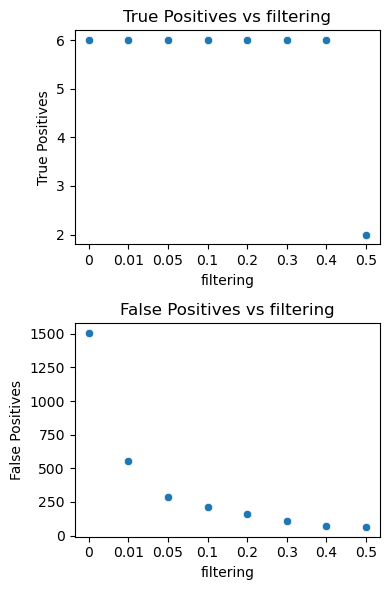

In [237]:
# Create the subplots
fig, axes = plt.subplots(2, 1, figsize=(4, 6))  # 1 row, 2 columns

# Plot the true positives in the first subplot
sns.scatterplot(data=results, x='filtering', y='true_pos', ax=axes[0])
axes[0].set_title('True Positives vs filtering')
axes[0].set_xlabel('filtering')
axes[0].set_ylabel('True Positives')

# Plot the false positives in the second subplot
sns.scatterplot(data=results, x='filtering', y='false_pos', ax=axes[1])
axes[1].set_title('False Positives vs filtering')
axes[1].set_xlabel('filtering')
axes[1].set_ylabel('False Positives')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
b